# Oh Numerics, Can You Tell Me What's Wrong?
When evaluating the rollout acquisition function near known sample locations, we observe something peculiar. Our acquisition function spikes, signaling that sampling in this region is perhaps a reasonable thing to do. After investigating this issue,

## Considerations
- [x] Check the conditioning of our linear system at these locations where we notice high acquisition
- [ ] Refactor code to get rid of the misconception of the mean field and zero mean of data assumption in our surrogates
- [ ] Fix the issue with the control variate random variable not taking the max of the sampled trajectories first step.

In [9]:
using Distributions
using LinearAlgebra
using Plots
using LaTeXStrings

In [35]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

In [106]:
MC_SAMPLES = 1000
NUMBER_OF_STARTS = 16
HORIZON = 0
BATCH_SIZE = 8
USE_LDS = true
NUMBER_OF_TRIALS = 1

# Gaussian process hyperparameters
θ, σn2 = [.25], 1e-6
ψ = kernel_matern52(θ)
# testfn = TestQuadratic1D(lb=-1., ub=1.)
testfn = TestLinearCosine1D(1., 13.2)
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

Xinit = randsample(7, 1, lbs, ubs)
# Xinit = [.85;; .8;; .9;; -.85;; -.8;; -.9;;]
yinit = testfn.f.(eachcol(Xinit))
# sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);
sur = optimize_hypers_optim(
    fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
    kernel_matern52
);

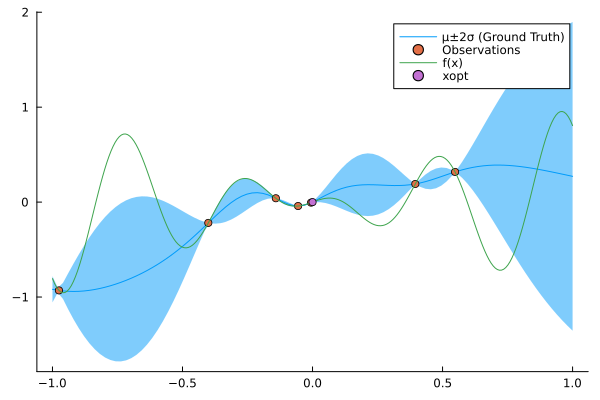

In [107]:
p = plot1D(sur; xmin=first(lbs), xmax=first(ubs))
xx = range(testfn.bounds[1,1], testfn.bounds[1,2], length=250)
plot!(xx, (x) -> testfn([x]), label="f(x)")
scatter!(p, [xy[1] for xy in testfn.xopt], [testfn(xy) for xy in testfn.xopt], label="xopt")

In [108]:
domain = first(lbs):.01:first(ubs)
dense_evals = zeros(length(domain), 4)
fde = similar(domain)
h = 1e-6

for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    dense_evals[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]

    tp.x0[:] = [x0 + h]
    outcomep = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    tp.x0[:] = [x0 - h]
    outcomem = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    fde[i] = (outcomep[1] - outcomem[1]) / 2h
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

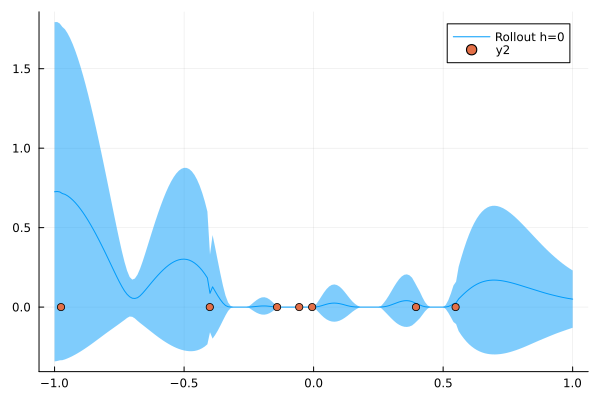

In [109]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))

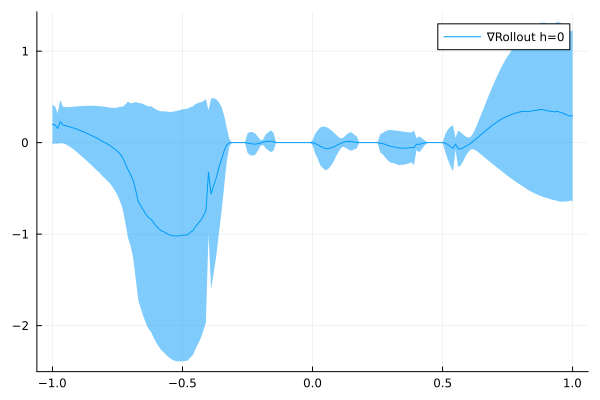

In [110]:
plot(
    domain,
    dense_evals[:, 2],
    ribbons=dense_evals[:, 4],
    label="∇Rollout h=$HORIZON"
)
# plot!(domain, fde)

## Investigating Interesting Numerics

In [32]:
# Find location that exhibits the numerical weirdness
xnew = [domain[findmax(dense_evals[:, 1])[2]]]
xnew = [.85]

# Setup for investigating surrogates with and without gradient observations
fsur = fit_fsurrogate(sur, 0)
msur = fit_multioutput_fsurrogate(sur, 0)

# Condition fsur and msur on the same observations
ynew = testfn(xnew)
∇ynew = testfn.∇f(xnew)
update_fsurrogate!(fsur, xnew, ynew)
update_multioutput_fsurrogate!(msur, xnew, ynew, ∇ynew)

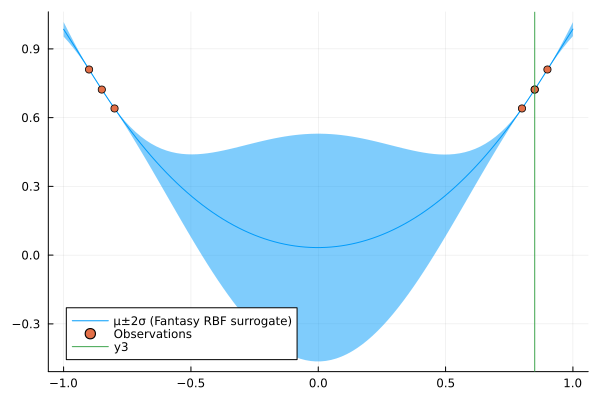

In [33]:
plot1D(fsur, xmin=domain[1], xmax=domain[end])
vline!(xnew)

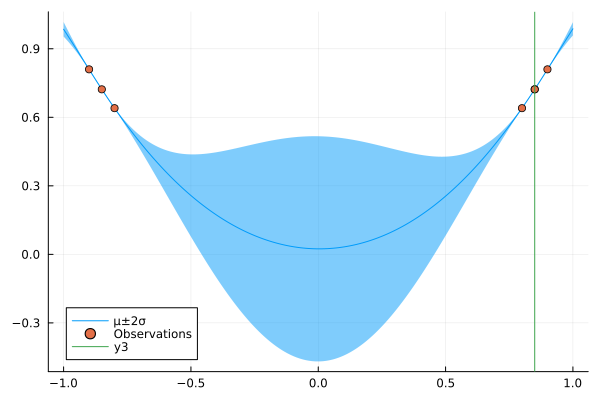

In [34]:
plot1D(msur, xmin=domain[1], xmax=domain[end], npts=500)
vline!(xnew)

In [30]:
msur2 = fit_multioutput_fsurrogate(sur, 4)
xlocs = range(domain[1], domain[end], length=5)

for x in xlocs
    x = [x]
    update_multioutput_fsurrogate!(msur2, x, testfn(x), testfn.∇f(x))
end

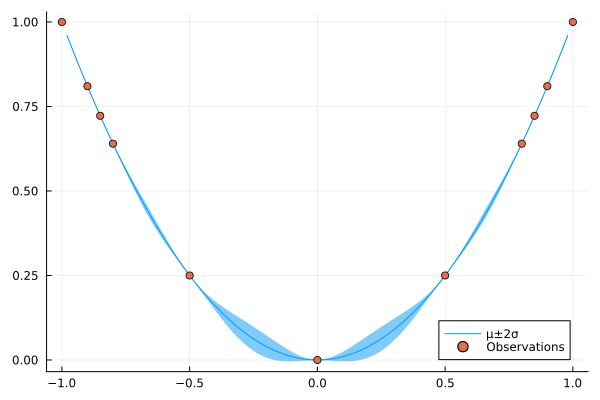

In [31]:
plot1D(msur2, xmin=domain[1], xmax=domain[end])